توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob
import math
from cv2 import imread as IM
from os import path
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.io import read_image
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split
from random import randint
import matplotlib.pyplot as plt


## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
# function 1
def displacement(img, factor):
  img = np.array(img)
  height, width, channels = img.shape
  if factor <= 1:
    dx = random.uniform(-(factor * width)/2 + 112, (factor * width)/2 - 112)
    dy = random.uniform(-(factor * height)/2 + 112, (factor * height)/2 - 112)
  else:
    dx = random.uniform(-width/2 + 112, width/2 - 112)
    dy = random.uniform(-height/2 + 112, height/2 - 112)
  dx = int(dx)
  dy = int(dy)
  shifted_image = np.roll(img, (dy, dx), axis=(0, 1))
  if dx > 0:
    shifted_image[:, :dx] = 0
  elif dx < 0:
    shifted_image[:, dx:] = 0
  if dy > 0:
    shifted_image[:dy, :] = 0
  elif dy < 0:
    shifted_image[dy:, :] = 0

  return shifted_image, dx, dy

# function 2
def rotation(img, factor ,dx, dy):
  if factor <= 1:
    min_value = min((factor * img.shape[0]) - 2*abs(dy), (factor * img.shape[1]) - 2*abs(dx))
  else:
    min_value = min((1 * img.shape[0]) - 2*abs(dy), (1 * img.shape[1]) - 2*abs(dx))
  cr = math.sqrt(2) * 224
  if min_value > cr:
    degree = random.choice([15, 30, 45, 60, 90])
  else:
    max_degree = 0.5 * math.degrees(math.asin(((min_value**2) / (224**2)) - 1))
    degree = random.uniform(0, max_degree)
  degree = math.radians(degree)
  rot_img = np.uint8(np.zeros(img.shape))
  height = rot_img.shape[0]
  width  = rot_img.shape[1]
  cx = int((height+1)/2)
  cy = int((width+1)/2)
  for i in range(rot_img.shape[0]):
    for j in range(rot_img.shape[1]):
      x= (i-cx)*math.cos(degree)+(j-cy)*math.sin(degree)
      y= -(i-cx)*math.sin(degree)+(j-cy)*math.cos(degree)
      x = x + cx
      y = y + cy
      x=round(x)
      y=round(y)
      if (x>=0 and y>=0 and x<img.shape[0] and  y<img.shape[1]):
        rot_img[i,j,:] = img[x,y,:]
  return rot_img

# # function 3
def scaling(img):
    h, w, c = img.shape
    min_scale_factor = 224 / min(h, w)
    factor = random.uniform(min_scale_factor, 2.0)
    scaled_img = np.zeros_like(img)

    resize = cv2.resize(img, None, fx=factor, fy=factor)
    zh, zw, _ = resize.shape

    if factor < 1:
        top = max((h - zh) // 2, 0)
        bottom = min(top + zh, h)
        left = max((w - zw) // 2, 0)
        right = min(left + zw, w)
        scaled_img[top:bottom, left:right, :] = resize
    else:
        top = max((zh - h) // 2, 0)
        bottom = min(top + h, zh)
        left = max((zw - w) // 2, 0)
        right = min(left + w, zw)
        scaled_img = resize[top:bottom, left:right, :]

    return scaled_img, factor

# function 4
def Brightness(img):
  a = 0.7
  brightened_img = ((255/(np.log(1 + 255*a)))*np.log(1 + img*a))
  return brightened_img.astype(np.uint8)

# function 5
def bluring(img):
  kernel_size = 5
  kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size * kernel_size)
  blurred_image = cv2.filter2D(img, -1, kernel)
  return blurred_image

# function 6
def gaussian_noise(img):
  row, col, ch = img.shape
  gauss_noise = np.random.normal(0, 30, (row, col, ch))
  img_gauss = img + gauss_noise
  noisy = np.clip(img_gauss, 0, 255)
  return noisy.astype(np.uint8)

# function 7
def crop(image, crop_size=(224, 224)):
    h, w, _ = image.shape
    start_h = max(0, (h - crop_size[0]) // 2)
    start_w = max(0, (w - crop_size[1]) // 2)
    cropped_image = image[start_h:start_h + crop_size[0], start_w:start_w + crop_size[1], :]
    return cropped_image

In [ ]:
dataset_path = '/content/ADEChallengeData2016'

# Define the path to the training images folder
training_images_path = os.path.join(dataset_path, 'images', 'training')

# Get a list of filenames in the training images folder
training_image_files = os.listdir(training_images_path)

In [ ]:
num_images_to_select = 4000
selected_images = random.sample(training_image_files, num_images_to_select)
first_800_images = selected_images[:800]
second_800_images = selected_images[800:1600]
third_800_images = selected_images[1600:2400]
first_500_images = selected_images[2400:2900]
second_500_images = selected_images[2900:3400]
third_500_images = selected_images[3400:3900]
last_100_images = selected_images[-100:]

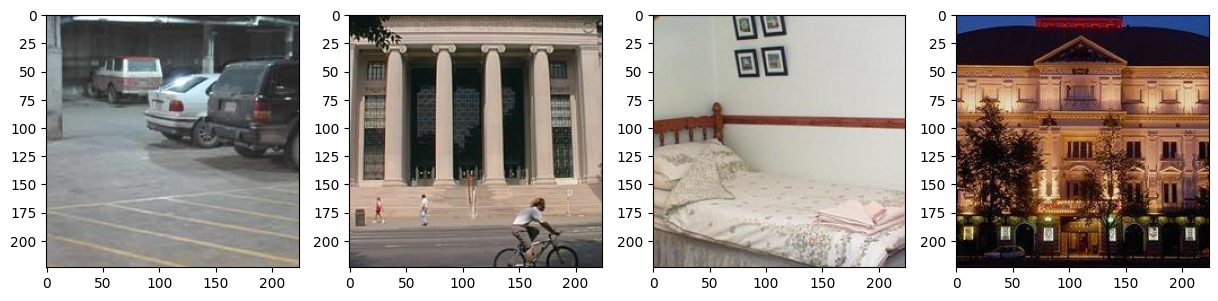

In [ ]:
cropped_images = []
for image_path in selected_images:
    image = plt.imread(os.path.join(training_images_path, image_path))
    cropped_image = crop(image)
    cropped_images.append(cropped_image)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(cropped_images[i])
plt.show()

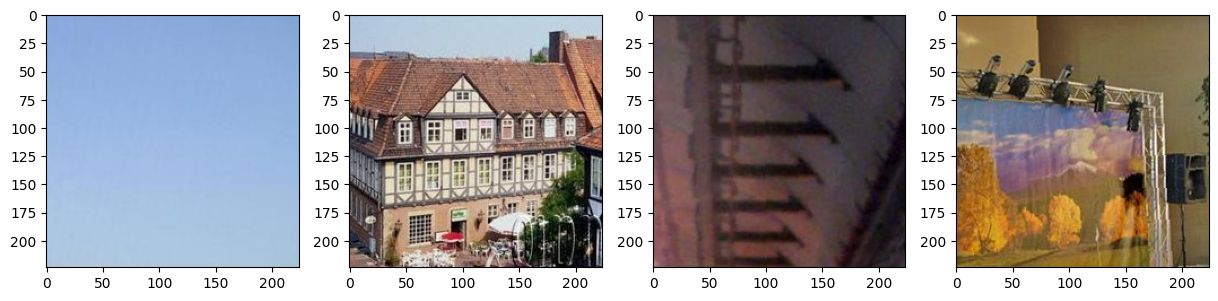

In [ ]:
augmented_first_800_images = []
for image_path  in first_800_images:
    image = plt.imread(os.path.join(training_images_path, image_path ))
    augmented_image ,dx,dy = displacement(image, factor=1)
    augmented_image1 = rotation(augmented_image, factor=1 , dx=dx, dy=dy)
    new_image1 = crop(augmented_image1)
    augmented_first_800_images.append(new_image1)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(augmented_first_800_images[i])
plt.show()


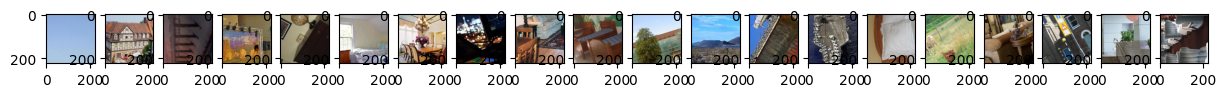

In [ ]:
fig, axes = plt.subplots(1, 20, figsize=(15, 5))
for i in range(20):
    axes[i].imshow(augmented_first_800_images[i])
plt.show()

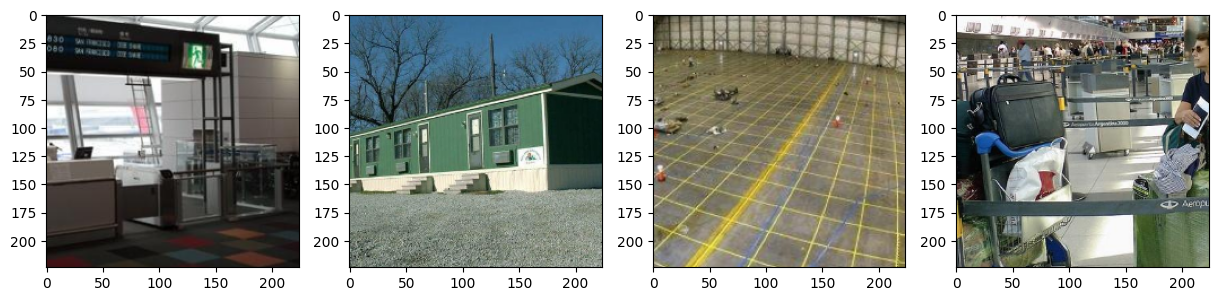

In [ ]:
# for scaling + displacement
augmented_second_800_images = []
for image_path in second_800_images:
  image = plt.imread(os.path.join(training_images_path, image_path ))
  augmented_image_1 , factor = scaling(image)
  augmented_image_2,dx,dy = displacement(augmented_image_1, factor=factor)
  new_image2 = crop(augmented_image_2)
  augmented_second_800_images.append(new_image2)

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(augmented_second_800_images[i])
plt.show()

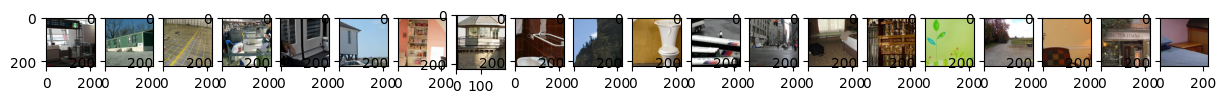

In [ ]:
fig, axes = plt.subplots(1, 20, figsize=(15, 5))
for i in range(20):
    axes[i].imshow(augmented_second_800_images[i])
plt.show()

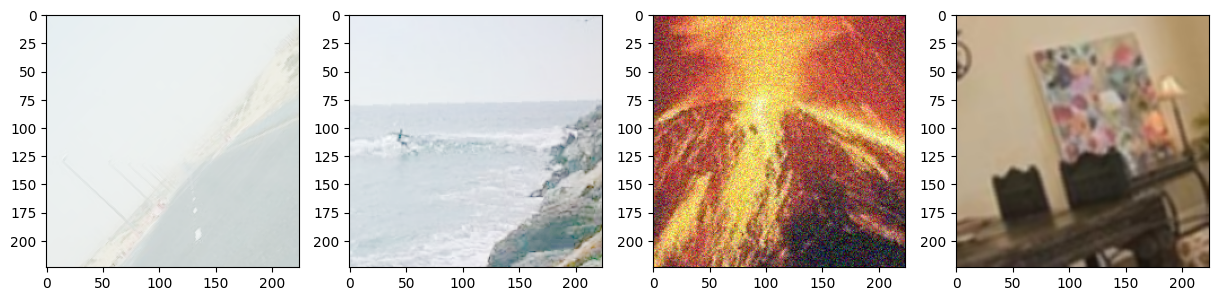

In [ ]:
# for scaling + rotation
augmented_third_800_images = []
for image_path in third_800_images:
  image = plt.imread(os.path.join(training_images_path, image_path ))
  augmented_image_1_ , factor = scaling(image)
  augmented_image_2_ = rotation(augmented_image_1_, factor=factor, dx=0, dy=0)
  new_image3 = crop(augmented_image_2_)
  random_function = random.choice([Brightness, bluring, gaussian_noise])
  new_image3 = random_function(new_image3)
  augmented_third_800_images.append(new_image3)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
for i in range(4):
    axes[i].imshow(augmented_third_800_images[i])
plt.show()

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, training=True, test=False):
        self.root_dir = root_dir
        self.training = training
        self.test = test

        if self.training and not self.test:
            # For training set
            all_training_image_paths = glob.glob(os.path.join(root_dir, 'images', 'training', '*.jpg'))
            self.image_paths = random.sample(all_training_image_paths, 5000)
        elif not self.test:
            # For validation set
            all_validation_image_paths = glob.glob(os.path.join(root_dir, 'images', 'validation', '*.jpg'))
            self.image_paths = random.sample(all_validation_image_paths, 1200)
        elif self.test:
            # For test set
            all_test_image_paths = glob.glob(os.path.join(root_dir, 'testing', '*.jpg'))
            self.image_paths = all_test_image_paths

        # if self.training:
        #     # For training set
        #     all_training_image_paths = glob.glob(os.path.join(root_dir, 'images', 'training', '*.jpg'))
        #     self.image_paths = random.sample(all_training_image_paths, 5000)
        # else:
        #     # For validation set
        #     all_validation_image_paths = glob.glob(os.path.join(root_dir, 'images', 'validation', '*.jpg'))
        #     self.image_paths = random.sample(all_validation_image_paths, 1200)

        self.num_samples = len(self.image_paths)
        self.labels = [
            [0, 0, 0],
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1]
        ]

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        label = random.choice(self.labels)
        img_path = self.image_paths[idx]
        original_image = cv2.imread(img_path)
        if min(original_image.shape[:2]) < 224:
          original_image = cv2.resize(original_image, (224, 224), interpolation=cv2.INTER_LINEAR)
        copy_of_image = np.copy(original_image)
        cropped_of_original_image = crop(copy_of_image)
        if label == [0, 0, 0]:
            new_image = crop(original_image)
            random_function = random.choice([Brightness, bluring, gaussian_noise])
            new_image = random_function(new_image)
            my_label = 0
        elif label == [1, 0, 0]:
            augmented_image_1_1, _, _ = displacement(original_image, factor=1)
            new_image = crop(augmented_image_1_1)
            random_function = random.choice([Brightness, bluring, gaussian_noise])
            new_image = random_function(new_image)
            my_label = 1
        elif label == [0, 1, 0]:
            augmented_image_1_1_ = rotation(original_image, factor=1, dx=0, dy=0)
            new_image = crop(augmented_image_1_1_)
            random_function = random.choice([Brightness, bluring, gaussian_noise])
            new_image = random_function(new_image)
            my_label = 2
        elif label == [0, 0, 1]:
            augmented_image_1_1_1, _ = scaling(original_image)
            new_image = crop(augmented_image_1_1_1)
            random_function = random.choice([Brightness, bluring, gaussian_noise])
            new_image = random_function(new_image)
            my_label = 3
        elif label == [1, 1, 0]:
            augmented_image, dx, dy = displacement(original_image, factor=1)
            augmented_image1 = rotation(augmented_image, factor=1, dx=dx, dy=dy)
            new_image = crop(augmented_image1)
            random_function = random.choice([Brightness, bluring, gaussian_noise])
            new_image = random_function(new_image)
            my_label = 4
        elif label == [1, 0, 1]:
            augmented_image_1, factor = scaling(original_image)
            augmented_image_2, _, _ = displacement(augmented_image_1, factor=factor)
            new_image = crop(augmented_image_2)
            random_function = random.choice([Brightness, bluring, gaussian_noise])
            new_image = random_function(new_image)
            my_label = 5
        elif label == [0, 1, 1]:
            augmented_image_1_, factor = scaling(original_image)
            augmented_image_2_ = rotation(augmented_image_1_, factor=factor, dx=0, dy=0)
            new_image = crop(augmented_image_2_)
            random_function = random.choice([Brightness, bluring, gaussian_noise])
            new_image = random_function(new_image)
            my_label = 6
        cropped_of_original_image = torch.from_numpy(cropped_of_original_image.transpose((2, 0, 1)))
        new_image = torch.from_numpy(new_image.transpose((2, 0, 1)))
        return cropped_of_original_image, new_image, my_label

In [8]:
dataset_path = '/content/ADEChallengeData2016'
dataset_test_path = '/content/release_test'
batch_size = 20  # Adjust the batch size as needed
# For training dataset
train_dataset = CustomDataset(root_dir=dataset_path, training=True, test=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# For validation dataset
val_dataset = CustomDataset(root_dir=dataset_path, training=False, test=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
# For test dataset
test_dataset = CustomDataset(root_dir=dataset_test_path, training=False, test=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)# print(len(train_loader))
# print(len(test_dataset))

# # dataset_train = CustomDataset(root_dir=dataset_path)
# # Print the shape of the first element in the dataset
# sample_index = 130
# input_image, target_image,target = train_dataset[sample_index]
# print("Input Image Shape:", input_image.shape)
# print("Target Image Shape:", target_image.shape)# Define your DataLoader
# # Convert PyTorch tensors to numpy arrays
# input_image_np = np.transpose(input_image.numpy(), (1, 2, 0))
# target_image_np = np.transpose(target_image.numpy(), (1, 2, 0))

# # Display the input image
# plt.subplot(1, 2, 1)
# plt.imshow(input_image_np)
# plt.title('Input Image')

# # Display the target image
# plt.subplot(1, 2, 2)
# plt.imshow(target_image_np)
# plt.title('Target Image')

# plt.show()

tensor(5)


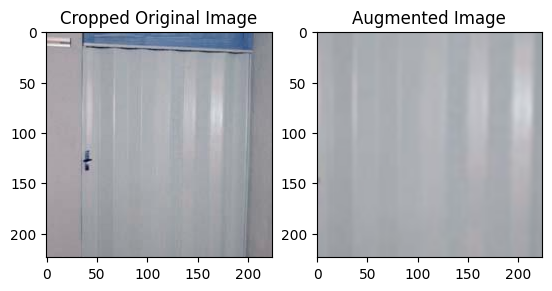

In [ ]:
for batch_idx, (cropped_of_original_images, new_images,labels) in enumerate(train_loader):
    cropped_of_original_image = cropped_of_original_images[15]
    new_image = new_images[15]
    label = labels[15]
    cropped_of_original_image_np = np.transpose(cropped_of_original_image.numpy(), (1, 2, 0))
    new_image_np = np.transpose(new_image.numpy(), (1, 2, 0))
    print(label)
    plt.subplot(1, 2, 1)
    plt.imshow(cropped_of_original_image_np)
    plt.title('Cropped Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(new_image_np)
    plt.title('Augmented Image')
    plt.show()
    break

In [ ]:
# dataset_train = CustomDataset()## To Do
# dataset_test = CustomDataset()## To Do
# dataset_val = CustomDataset()## To Do
# train_loader = DataLoader()## To Do
# test_loader= DataLoader()## To Do
# val_loader = DataLoader()## To Do

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

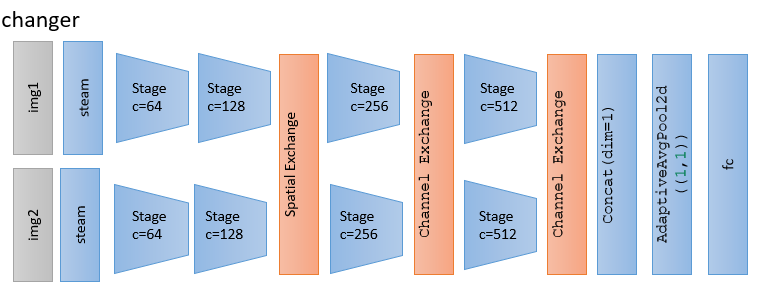

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


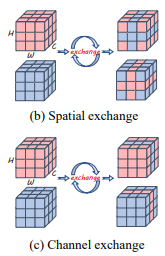

In [9]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

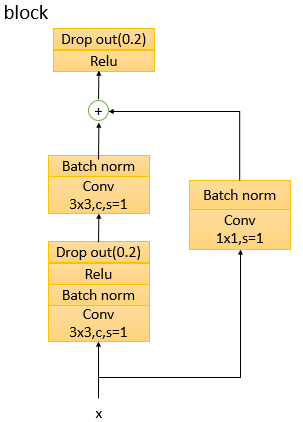

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟

تعداد کانال برای بلوک کانولوشن 1*1 را برابر 1 در نظر گرفتم.
در واقع می توان گفت این مسیر به نوعی مانند مسیر رزیجوآل می باشد که باعث می شود اطلاعات وروردی تا حدی به خروجی منتقل شود  و همچنین می تواند مانند رگولاریزیشن عمل کند و از مواجه شدن با مشکلاتی همچون گرادیان ونشینیگ جلوگیری کند



In [10]:
##To Do
class block(nn.Module):
  def __init__(self, x, c):
    super(block,self).__init__()
    self.path1 = nn.Sequential(
        nn.Conv2d(x, c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(c),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(c)
        )
    self.path2 = nn.Sequential(
        nn.Conv2d(x, 1, kernel_size=1, stride=1),
        nn.BatchNorm2d(1)
        )
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout2d(0.2)

  def forward(self,x):
    out1 = self.path1(x)
    out2 = self.path2(x)
    out = out1 + out2
    out = self.relu(out)
    out = self.dropout(out)
    return out

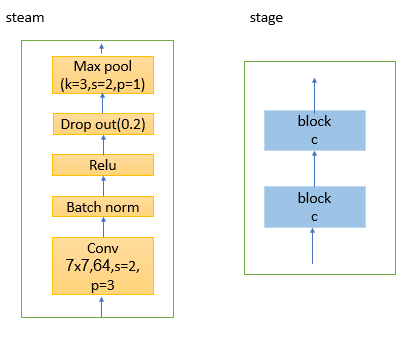

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [11]:
#To Do
class changer(nn.Module):
  def __init__(self, block,SpatialExchange, ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    self.block = block
    self.spatial_exchange = SpatialExchange()
    self.channel_exchange = ChannelExchange()
    self.stage1 = self._make_stage(64,64)
    self.stage2 = self._make_stage(64,128)
    self.stage3 = self._make_stage(128,256)
    self.stage4 = self._make_stage(256,512)
    self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(1024, 7)

  def _make_stage(self, x, c):
    layers=[self.block(x,c),self.block(c,c)]
    return nn.Sequential(*layers)

  def forward(self,x1,x2):
    steam_out1 = self.steam(x1)
    steam_out2 = self.steam(x2)

    # Stage Blocks 1,2
    stage1_out1 = self.stage1(steam_out1)
    stage1_out2 = self.stage1(steam_out2)

    stage2_out1 = self.stage2(stage1_out1)
    stage2_out2 = self.stage2(stage1_out2)

    # Spatial Exchange
    spatial_exchange_out1, spatial_exchange_out2 = self.spatial_exchange(stage2_out1, stage2_out2)

    # Stage Blocks 3
    stage3_out1 = self.stage3(spatial_exchange_out1)
    stage3_out2 = self.stage3(spatial_exchange_out2)

    # Channel Exchange 1
    channel_exchange_out1, channel_exchange_out2 = self.channel_exchange(stage3_out1, stage3_out2)

    # Stage Block 4
    stage4_out1 = self.stage4(channel_exchange_out1)
    stage4_out2 = self.stage4(channel_exchange_out2)

    # Channel Exchange 2
    channel_exchange_out1_, channel_exchange_out2_ = self.channel_exchange(stage4_out1, stage4_out2)

    # Concatenate block
    concat_out = torch.cat((channel_exchange_out1_, channel_exchange_out2_),dim=1)

    # AdaptiveAvgPool2d
    avg_pool_out = self.avg_pool(concat_out)

    # Fully Connected layer
    output = self.fc(avg_pool_out.squeeze())
    return output

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = changer(block, SpatialExchange, ChannelExchange).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001 )

##Train & validation


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
CHECKPOINT_FOLDER = 'deepHW3/Q3/checkpoints'
checkpoint_folder_path = os.path.join('/content/drive/My Drive', CHECKPOINT_FOLDER)
os.makedirs(checkpoint_folder_path, exist_ok=True)

In [ ]:
additional_epochs = 5
checkpoint_path = os.path.join(checkpoint_folder_path, "model_checkpoint_epoch_18.pt")
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

Loss_train = []
Loss_val=[]

# Training loop
num_epochs = start_epoch + additional_epochs
print_interval = 50
# Training loop for additional epochs
for epoch in range(start_epoch, num_epochs ):
    total_loss_train = 0.0
    total_correct_train = 0
    total_samples_train = 0
    model.train()

    for batch_idx, (cropped_of_original_images, new_images, labels) in enumerate(train_loader):
        cropped_of_original_images = cropped_of_original_images.to(device)
        new_images = new_images.to(device)
        labels = labels.to(device)
        cropped_of_original_images = cropped_of_original_images.to(dtype=torch.float32)
        new_images = new_images.to(dtype=torch.float32)

        # Forward pass
        outputs = model(cropped_of_original_images, new_images)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_train += loss.item()

        # Compute accuracy
        _, predicted = outputs.max(1)
        total_correct_train += (predicted == labels).sum().item()
        total_samples_train += labels.size(0)

        # Print loss and accuracy every print_interval batches
        if (batch_idx + 1) % print_interval == 0:
            batch_accuracy = (predicted == labels).sum().item() / labels.size(0)
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.3f}, Accuracy: {batch_accuracy:.3f}')

    avg_loss_train = total_loss_train / len(train_loader)
    accuracy_train = total_correct_train / total_samples_train
    Loss_train.append(avg_loss_train)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg. Training Loss: {avg_loss_train:.3f}, Avg. Training Accuracy: {accuracy_train:.3f}')
    checkpoint_path = os.path.join(checkpoint_folder_path, f"model_checkpoint_epoch_{epoch + 1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss_train,
    }, checkpoint_path)

    # Validation loop
    model.eval()
    total_loss_val = 0.0
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for batch_idx, (cropped_of_original_images, new_images, labels) in enumerate(val_loader):
            cropped_of_original_images = cropped_of_original_images.to(device)
            new_images = new_images.to(device)
            labels = labels.to(device)
            cropped_of_original_images = cropped_of_original_images.to(dtype=torch.float32)
            new_images = new_images.to(dtype=torch.float32)
            outputs = model(cropped_of_original_images, new_images)
            loss = criterion(outputs, labels)
            total_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct_val += (predicted == labels).sum().item()
            total_samples_val += labels.size(0)
    avg_loss_val = total_loss_val / len(val_loader)
    accuracy_val = total_correct_val / total_samples_val
    Loss_val.append(avg_loss_val)
    print(f'Epoch {epoch+1}/{num_epochs}, Avg. Validation Loss: {avg_loss_val:.3f}, Avg. Validation Accuracy: {accuracy_val:.3f}')

Epoch 20/24, Batch 50/250, Loss: 1.568, Accuracy: 0.400
Epoch 20/24, Batch 100/250, Loss: 1.768, Accuracy: 0.200
Epoch 20/24, Batch 150/250, Loss: 1.416, Accuracy: 0.450
Epoch 20/24, Batch 200/250, Loss: 1.503, Accuracy: 0.350
Epoch 20/24, Batch 250/250, Loss: 1.828, Accuracy: 0.300
Epoch 20/24, Avg. Training Loss: 1.631, Avg. Training Accuracy: 0.301
Epoch 20/24, Avg. Validation Loss: 1.581, Avg. Validation Accuracy: 0.329
Epoch 21/24, Batch 50/250, Loss: 1.577, Accuracy: 0.400
Epoch 21/24, Batch 100/250, Loss: 1.621, Accuracy: 0.200
Epoch 21/24, Batch 150/250, Loss: 1.446, Accuracy: 0.300
Epoch 21/24, Batch 200/250, Loss: 1.692, Accuracy: 0.350
Epoch 21/24, Batch 250/250, Loss: 1.728, Accuracy: 0.250
Epoch 21/24, Avg. Training Loss: 1.626, Avg. Training Accuracy: 0.296
Epoch 21/24, Avg. Validation Loss: 1.582, Avg. Validation Accuracy: 0.319


KeyboardInterrupt: ignored

#Test


In [15]:
checkpoint_path = os.path.join(checkpoint_folder_path, "model_checkpoint_epoch_20.pt")
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
total_loss_test = 0.0
total_correct_test = 0
total_samples_test = 0
with torch.no_grad():
    for batch_idx, (cropped_of_original_images, new_images, labels) in enumerate(test_loader):
        cropped_of_original_images = cropped_of_original_images.to(device)
        new_images = new_images.to(device)
        labels = labels.to(device)
        cropped_of_original_images = cropped_of_original_images.to(dtype=torch.float32)
        new_images = new_images.to(dtype=torch.float32)
        outputs = model(cropped_of_original_images, new_images)
        loss = criterion(outputs, labels)
        total_loss_test += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct_test += (predicted == labels).sum().item()
        total_samples_test += labels.size(0)
avg_loss_test = total_loss_test / len(test_loader)
accuracy_test = total_correct_test / total_samples_test
print(f'Test Loss: {avg_loss_test:.3f}, Test Accuracy: {accuracy_test:.3f}')

Test Loss: 1.556, Test Accuracy: 0.322


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟